In [72]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
import os
from os.path import join
import re
import math
from sklearn.preprocessing import StandardScaler
from statsmodels.tsa.seasonal import STL

# Funções Úteis

In [73]:
def create_correlation_matrix(
    df: pd.DataFrame, 
    columns: list[str],
    additional_title: str = ""):

    """
    Creates a correlation matrix for the given DataFrame.

    Parameters
    ----------
    df: pd.DataFrame
        The input DataFrame to calculate the correlation matrix for.
    columns: list[str]
        The list of column names to include in the correlation matrix.
    additional_title: str, optional
        An additional title to add to the correlation matrix plot, by default "".
    """

    corr_matrix = df.corr().values
    mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

    fig, ax = plt.subplots(figsize=(16, 8))
    sns.heatmap(corr_matrix, mask=mask, annot=True, xticklabels=columns, yticklabels=columns, cmap="YlGnBu", cbar=True)
    plt.title(f"Correlação entre Variáveis {additional_title}")
    plt.show()

In [74]:
def create_residual_df(
    df: pd.DataFrame,
    numerical_cols: list[str],
    seasonal_period: int = 7):

    residual_df = df.copy()

    for col in numerical_cols:
        feature_decomposition = STL(residual_df[col], period=seasonal_period).fit()
        residual_df[col] = residual_df[col] - feature_decomposition.seasonal.values

    return residual_df

# Coleta de Dados

In [75]:
MODULE_PATH = Path().absolute().parent
DATA_PATH = join(MODULE_PATH, "sources/processed")

In [76]:
complete_data = pd.read_csv(join(DATA_PATH, "mean_complete_df.csv"))

In [77]:
complete_data["data"] = pd.to_datetime(complete_data["data"])

In [78]:
complete_data.head()

,ano,mes,data,precipitacao_total_media,pressao_atm_hora_media,pressao_atm_max_media,pressao_atm_min_media,radiacao_global_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,...,vento_rajada_max_media,vento_velocidade_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,CO,MP10,MP2.5,O3,SO2
0,2009,1,2009-01-01,0.149600,970.670937,970.970238,970.382433,2440.168444,25.187439,20.299029,...,4.916689,2.073606,0,1,0,NaN,NaN,NaN,NaN,NaN
1,2009,1,2009-01-02,0.305735,969.614982,969.943108,969.351788,2291.531625,24.722086,20.084109,...,5.280309,2.194251,0,1,0,NaN,NaN,NaN,NaN,NaN
2,2009,1,2009-01-03,0.434014,968.136010,968.457802,967.834482,2149.246228,24.058518,19.749311,...,6.187021,2.625103,0,1,0,NaN,NaN,NaN,NaN,NaN
3,2009,1,2009-01-04,0.245052,969.021543,969.286433,968.697055,2145.260562,23.368056,18.715145,...,5.869366,2.534304,0,1,0,NaN,NaN,NaN,NaN,NaN
4,2009,1,2009-01-05,0.201583,970.262052,970.526035,969.998734,2174.907500,23.101135,17.945004,...,4.674361,1.944461,0,1,0,NaN,NaN,NaN,NaN,NaN


# Feature Selection

In [79]:
feature_cols = [feature for feature in complete_data.columns if feature not in ["id_estacao", "data", "ano", "mes"]]
numerical_cols = [feature for feature in feature_cols if complete_data[feature].dtype in ["float64"]]
categorical_cols = [feature for feature in feature_cols if complete_data[feature].dtype in ["int64", "object"]]

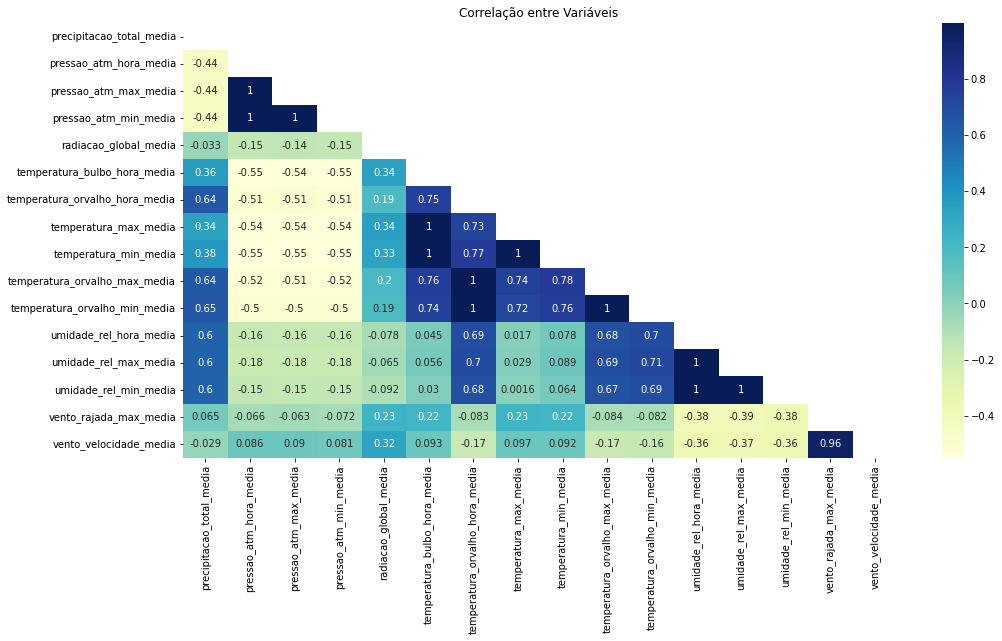

In [80]:
create_correlation_matrix(
    df=complete_data[numerical_cols],
    columns=numerical_cols
)

In [81]:
selected_numerical_features = [
    "precipitacao_total_media",
    "temperatura_bulbo_hora_media",
    "temperatura_orvalho_hora_media",
    "umidade_rel_hora_media"]

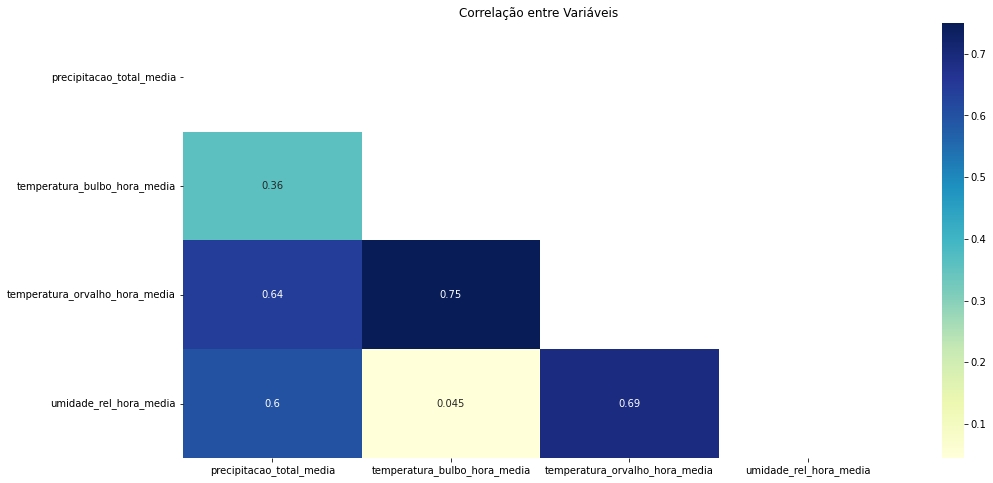

In [82]:
create_correlation_matrix(
    df=complete_data[selected_numerical_features],
    columns=selected_numerical_features
)

In [83]:
filtered_data = complete_data[selected_numerical_features + categorical_cols[:3]]
filtered_data.head()

,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro
0,0.149600,25.187439,20.299029,76.026835,0,1,0
1,0.305735,24.722086,20.084109,77.689743,0,1,0
2,0.434014,24.058518,19.749311,78.933681,0,1,0
3,0.245052,23.368056,18.715145,77.340627,0,1,0
4,0.201583,23.101135,17.945004,75.597683,0,1,0


# Definindo um "Ground Truth" Inicial

## Dados Crús

In [119]:
# Pontos de Ação:
# 1. Separar em treino/teste antes de definir o que é um outlier;
# 2. Revisar resultados individuais de outliers;
# 3. Avaliar Outliers após a decomposição sazonal;
# 4. Analisar outros métodos de definição de Ground Truth. Ex.: IQR
scaler = StandardScaler()
scaled_data = scaler.fit_transform(filtered_data[selected_numerical_features])
scaled_data = pd.DataFrame(scaled_data, columns=selected_numerical_features)

In [85]:
for col in scaled_data.columns:
    scaled_data[f'{col}_outlier'] = ((scaled_data[col] > 2) | (scaled_data[col] < -2))
    scaled_data[f'{col}_outlier'] = scaled_data[f'{col}_outlier'].astype(int)

In [86]:
scaled_data["total_outliers"] = ((scaled_data > 2) | (scaled_data < -2)).sum(axis=1)

In [87]:
scaled_data.head()

,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,precipitacao_total_media_outlier,temperatura_bulbo_hora_media_outlier,temperatura_orvalho_hora_media_outlier,umidade_rel_hora_media_outlier,total_outliers
0,-0.173010,0.856752,1.053876,0.597032,0,0,0,0,0
1,1.229295,0.607994,0.969148,0.883477,0,0,0,0,0
2,2.381407,0.253280,0.837161,1.097752,1,0,0,0,1
3,0.684281,-0.115812,0.429463,0.823340,0,0,0,0,0
4,0.293870,-0.258496,0.125852,0.523108,0,0,0,0,0


### Visualizando Outliers (Ground Truth)

In [88]:
outlier_cols = [col for col in scaled_data.columns if col.endswith('_outlier')]

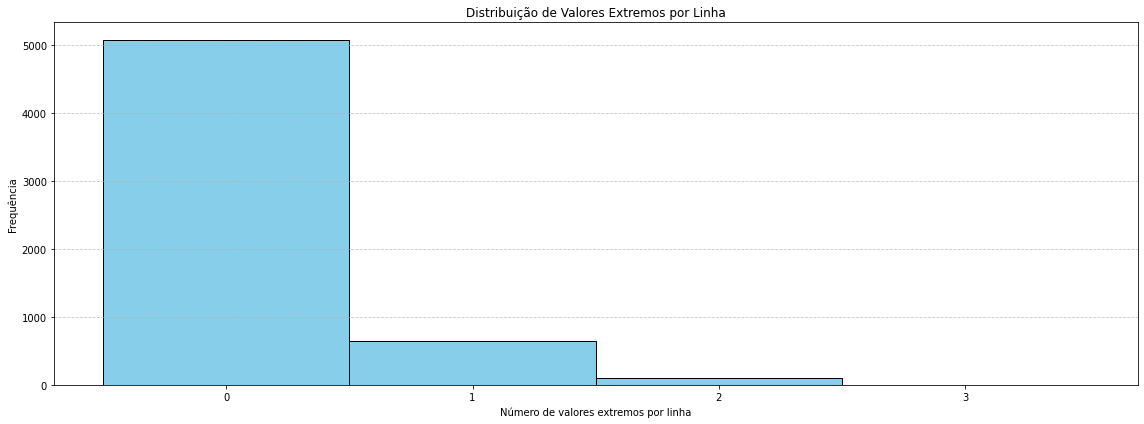

In [89]:
plt.figure(figsize=(16, 6))
plt.hist(scaled_data['total_outliers'], bins=range(scaled_data['total_outliers'].max() + 2), align='left', color='skyblue', edgecolor='black')
plt.title('Distribuição de Valores Extremos por Linha')
plt.xlabel('Número de valores extremos por linha')
plt.ylabel('Frequência')
plt.xticks(range(scaled_data['total_outliers'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [90]:
scaled_data["total_outliers"].value_counts()

total_outliers
0    5084
1     649
2     103
3       8
Name: count, dtype: int64

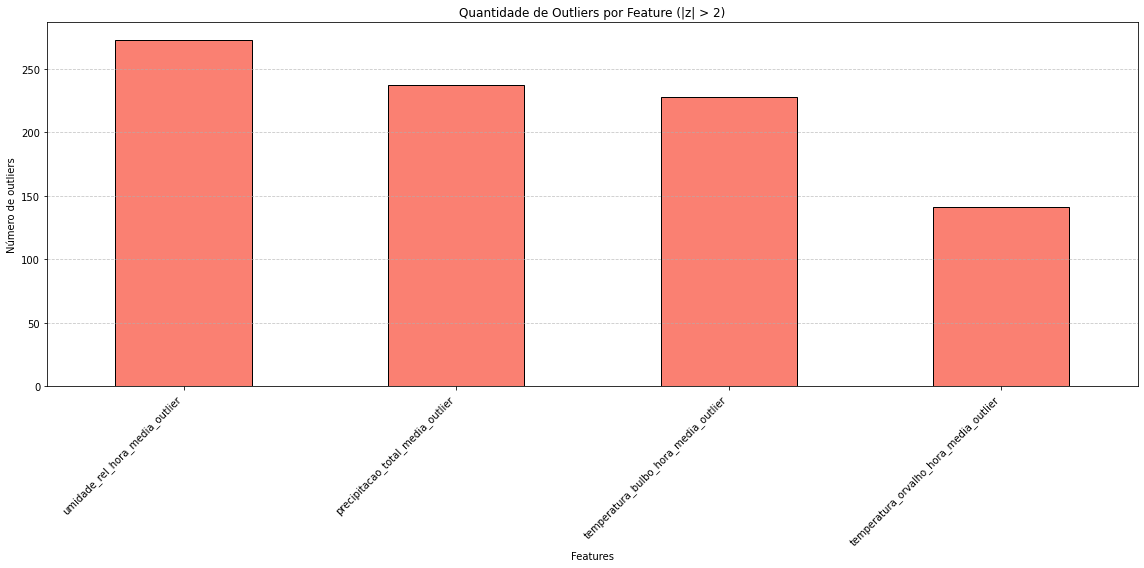

In [91]:
outliers_by_feature = scaled_data[outlier_cols].sum().sort_values(ascending=False)

# Opcional: ajustar o nome das colunas removendo o sufixo "_extremo" para exibir no gráfico
outliers_by_feature.index = [col.replace('_extremo', '') for col in outliers_by_feature.index]

# Plot do histograma de outliers por feature
plt.figure(figsize=(16, 8))
outliers_by_feature.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Quantidade de Outliers por Feature (|z| > 2)')
plt.ylabel('Número de outliers')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

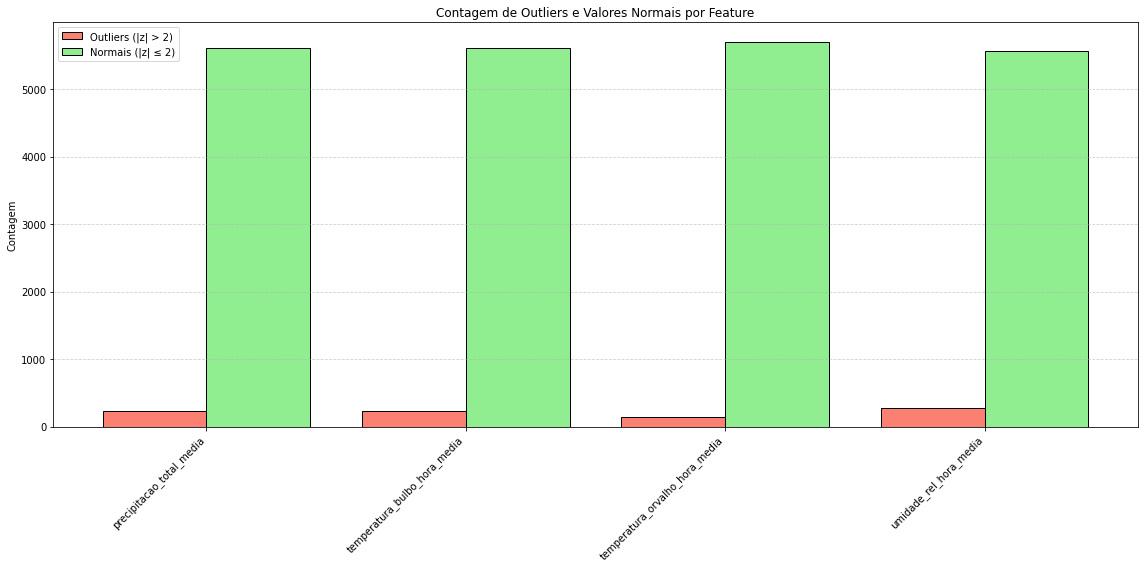

In [92]:
features = [col.replace('_outlier', '') for col in outlier_cols]

outlier_data = pd.DataFrame({
    'feature': features,
    'outliers': [scaled_data[col].sum() for col in outlier_cols],
    'normais': [len(scaled_data) - scaled_data[col].sum() for col in outlier_cols]
})

x = np.arange(len(outlier_data))
width = 0.4

# Plot
plt.figure(figsize=(16, 8))
plt.bar(x - width/2, outlier_data['outliers'], width=width, label='Outliers (|z| > 2)', color='salmon', edgecolor='black')
plt.bar(x + width/2, outlier_data['normais'], width=width, label='Normais (|z| ≤ 2)', color='lightgreen', edgecolor='black')

# Labels e layout
plt.xticks(x, outlier_data['feature'], rotation=45, ha='right')
plt.ylabel('Contagem')
plt.title('Contagem de Outliers e Valores Normais por Feature')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

In [ ]:
filtered_data_raw = pd.concat([complete_data[["ano", "mes", "data"]], filtered_data, scaled_data[outlier_cols + ["total_outliers"]]], axis=1)

In [94]:
filtered_data_raw.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,precipitacao_total_media_outlier,temperatura_bulbo_hora_media_outlier,temperatura_orvalho_hora_media_outlier,umidade_rel_hora_media_outlier,total_outliers
0,2009,1,2009-01-01,0.149600,25.187439,20.299029,76.026835,0,1,0,0,0,0,0,0
1,2009,1,2009-01-02,0.305735,24.722086,20.084109,77.689743,0,1,0,0,0,0,0,0
2,2009,1,2009-01-03,0.434014,24.058518,19.749311,78.933681,0,1,0,1,0,0,0,1
3,2009,1,2009-01-04,0.245052,23.368056,18.715145,77.340627,0,1,0,0,0,0,0,0
4,2009,1,2009-01-05,0.201583,23.101135,17.945004,75.597683,0,1,0,0,0,0,0,0


### Visualizando Outliers por Feature

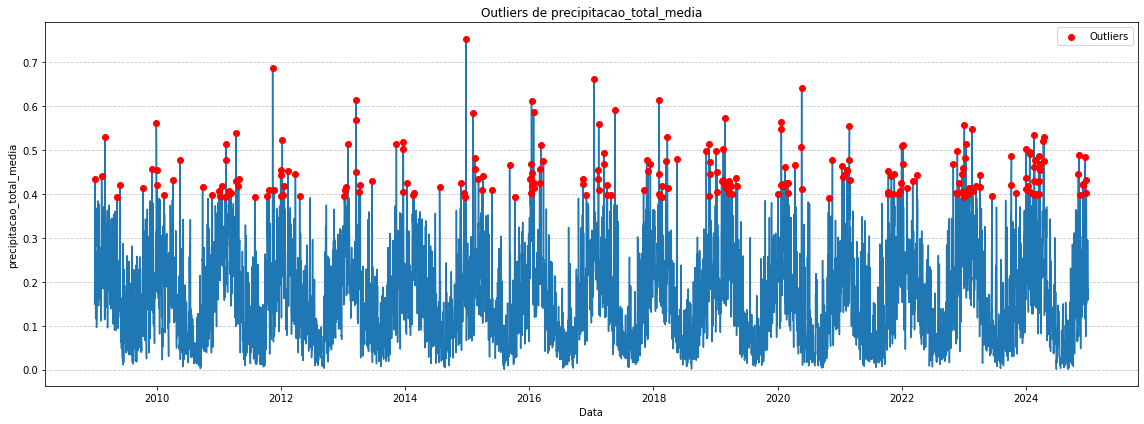

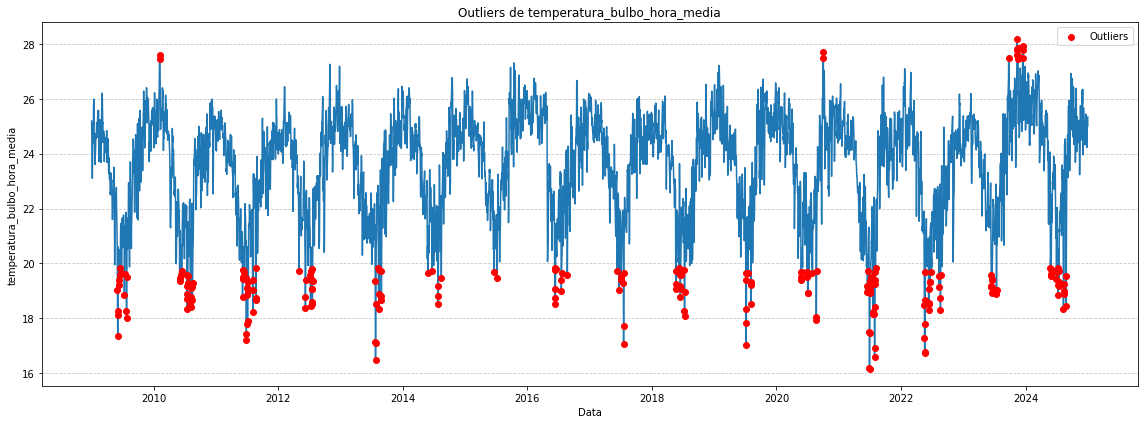

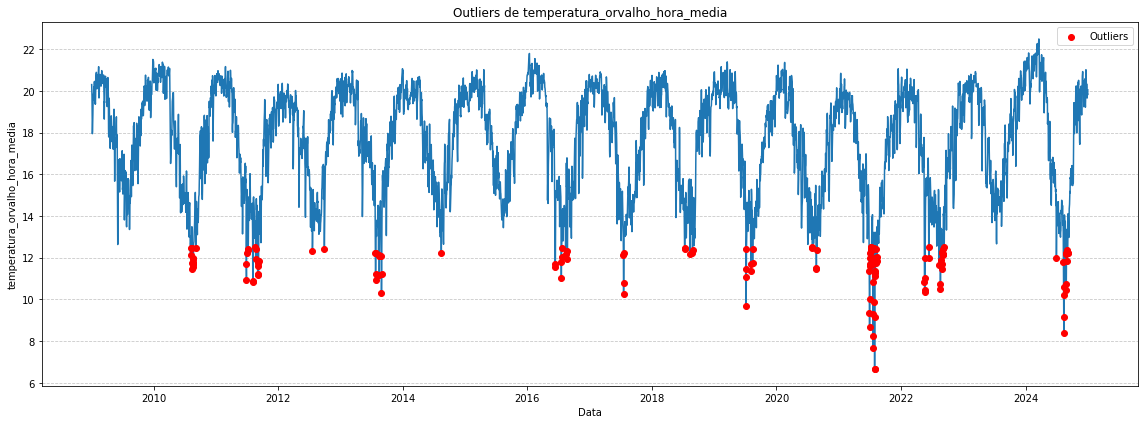

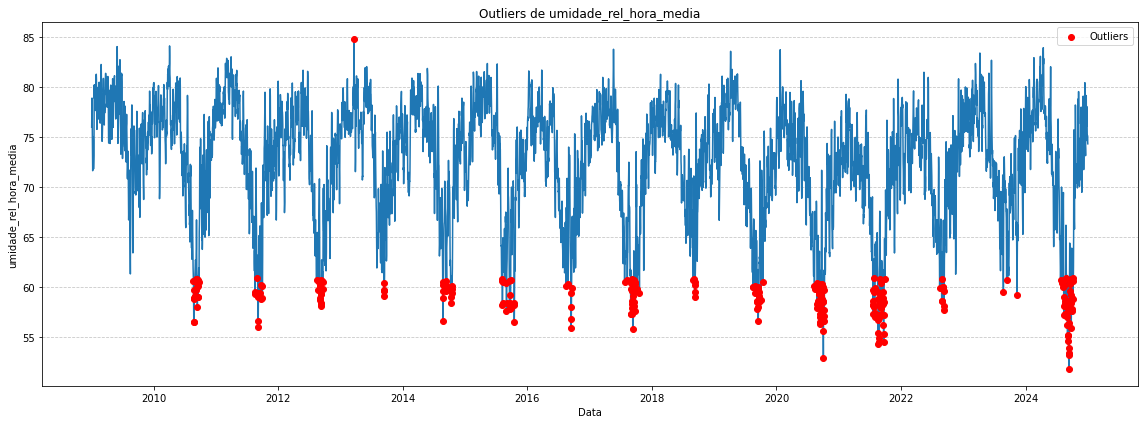

In [95]:
for feature in selected_numerical_features:

    feature_data = filtered_data_raw[["data", feature]]
    feature_data = feature_data.set_index("data")

    feature_labels = filtered_data_raw[["data", f"{feature}_outlier"]]
    feature_labels = feature_labels.set_index("data")

    feature_outliers = feature_labels[feature_labels == 1].dropna().index

    plt.figure(figsize=(16, 6))
    plt.plot(feature_data.index, feature_data[feature])
    plt.scatter(
        feature_outliers, 
        feature_data.loc[feature_outliers], 
        color='red',
        label='Outliers',
        zorder=3)
    plt.title(f"Outliers de {feature}")
    plt.xlabel("Data")
    plt.ylabel(feature)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

## Dados Decompostos

In [ ]:
residual_data = create_residual_df(
    df=filtered_data, 
    numerical_cols=selected_numerical_features)

In [97]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(residual_data[selected_numerical_features])
scaled_data = pd.DataFrame(scaled_data, columns=selected_numerical_features)

In [98]:
for col in scaled_data.columns:
    scaled_data[f'{col}_outlier'] = ((scaled_data[col] > 2) | (scaled_data[col] < -2))
    scaled_data[f'{col}_outlier'] = scaled_data[f'{col}_outlier'].astype(int)

In [99]:
scaled_data["total_outliers"] = ((scaled_data > 2) | (scaled_data < -2)).sum(axis=1)

In [100]:
scaled_data.head()

,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,precipitacao_total_media_outlier,temperatura_bulbo_hora_media_outlier,temperatura_orvalho_hora_media_outlier,umidade_rel_hora_media_outlier,total_outliers
0,0.568655,0.457533,0.772189,0.714493,0,0,0,0,0
1,0.619540,0.443708,0.651090,0.555172,0,0,0,0,0
2,0.896474,0.322538,0.538091,0.522684,0,0,0,0,0
3,0.217954,0.199000,0.452273,0.481369,0,0,0,0,0
4,0.704339,0.042545,0.406541,0.621279,0,0,0,0,0


### Visualizando Outliers (Ground Truth)

In [101]:
outlier_cols = [col for col in scaled_data.columns if col.endswith('_outlier')]

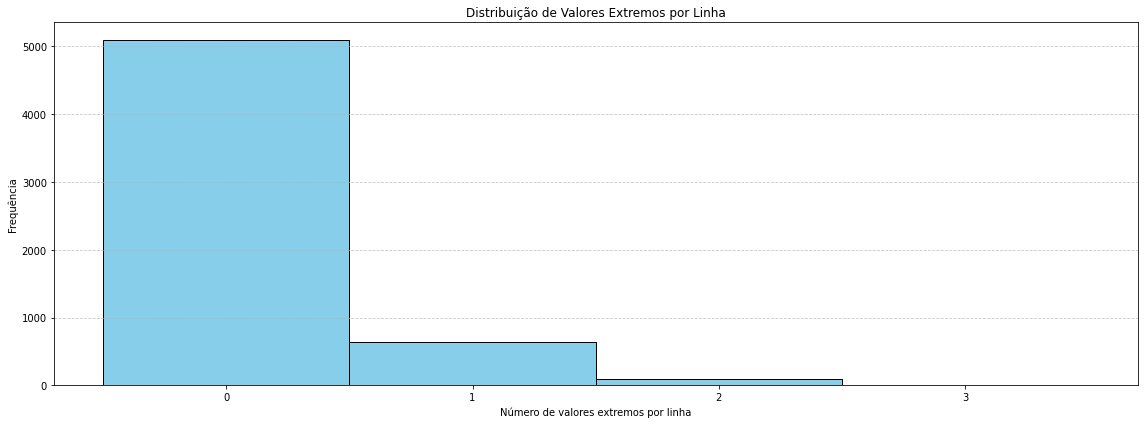

In [102]:
plt.figure(figsize=(16, 6))
plt.hist(scaled_data['total_outliers'], bins=range(scaled_data['total_outliers'].max() + 2), align='left', color='skyblue', edgecolor='black')
plt.title('Distribuição de Valores Extremos por Linha')
plt.xlabel('Número de valores extremos por linha')
plt.ylabel('Frequência')
plt.xticks(range(scaled_data['total_outliers'].max() + 1))
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [103]:
scaled_data["total_outliers"].value_counts()

total_outliers
0    5100
1     637
2      99
3       8
Name: count, dtype: int64

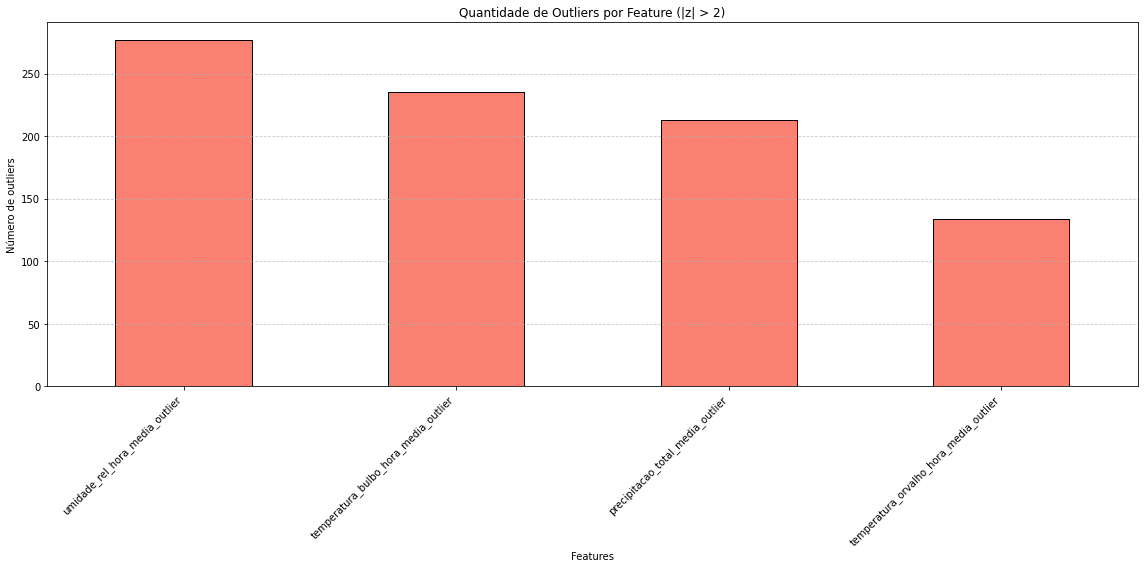

In [104]:
outliers_by_feature = scaled_data[outlier_cols].sum().sort_values(ascending=False)

# Opcional: ajustar o nome das colunas removendo o sufixo "_extremo" para exibir no gráfico
outliers_by_feature.index = [col.replace('_extremo', '') for col in outliers_by_feature.index]

# Plot do histograma de outliers por feature
plt.figure(figsize=(16, 8))
outliers_by_feature.plot(kind='bar', color='salmon', edgecolor='black')
plt.title('Quantidade de Outliers por Feature (|z| > 2)')
plt.ylabel('Número de outliers')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

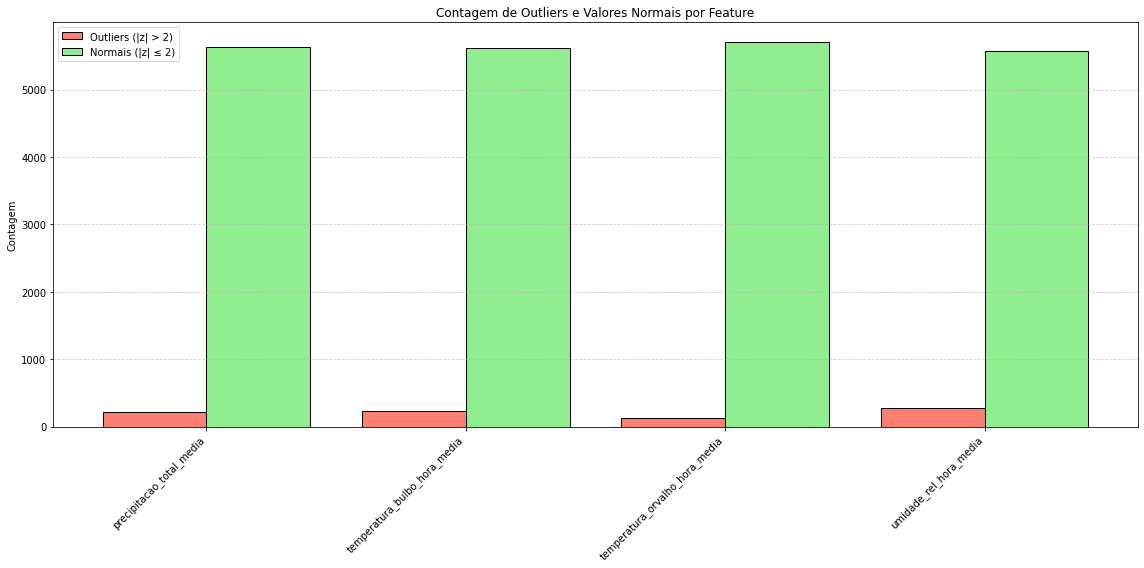

In [105]:
features = [col.replace('_outlier', '') for col in outlier_cols]

outlier_data = pd.DataFrame({
    'feature': features,
    'outliers': [scaled_data[col].sum() for col in outlier_cols],
    'normais': [len(scaled_data) - scaled_data[col].sum() for col in outlier_cols]
})

x = np.arange(len(outlier_data))
width = 0.4

# Plot
plt.figure(figsize=(16, 8))
plt.bar(x - width/2, outlier_data['outliers'], width=width, label='Outliers (|z| > 2)', color='salmon', edgecolor='black')
plt.bar(x + width/2, outlier_data['normais'], width=width, label='Normais (|z| ≤ 2)', color='lightgreen', edgecolor='black')

# Labels e layout
plt.xticks(x, outlier_data['feature'], rotation=45, ha='right')
plt.ylabel('Contagem')
plt.title('Contagem de Outliers e Valores Normais por Feature')
plt.legend()
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()

In [114]:
filtered_data_residual = pd.concat([complete_data[["ano", "mes", "data"]], residual_data, scaled_data[outlier_cols + ["total_outliers"]]], axis=1)

In [115]:
filtered_data_residual.head()

,ano,mes,data,precipitacao_total_media,temperatura_bulbo_hora_media,temperatura_orvalho_hora_media,umidade_rel_hora_media,categoria_El Ninõ,categoria_La Ninã,categoria_Neutro,precipitacao_total_media_outlier,temperatura_bulbo_hora_media_outlier,temperatura_orvalho_hora_media_outlier,umidade_rel_hora_media_outlier,total_outliers
0,2009,1,2009-01-01,0.227310,24.427236,19.569250,76.642464,0,1,0,0,0,0,0,0
1,2009,1,2009-01-02,0.232541,24.401773,19.264422,75.732239,0,1,0,0,0,0,0,0
2,2009,1,2009-01-03,0.261010,24.178610,18.979985,75.546629,0,1,0,0,0,0,0,0
3,2009,1,2009-01-04,0.191257,23.951086,18.763966,75.310594,0,1,0,0,0,0,0,0
4,2009,1,2009-01-05,0.241258,23.662936,18.648852,76.109919,0,1,0,0,0,0,0,0


### Visualizando Outliers por Feature

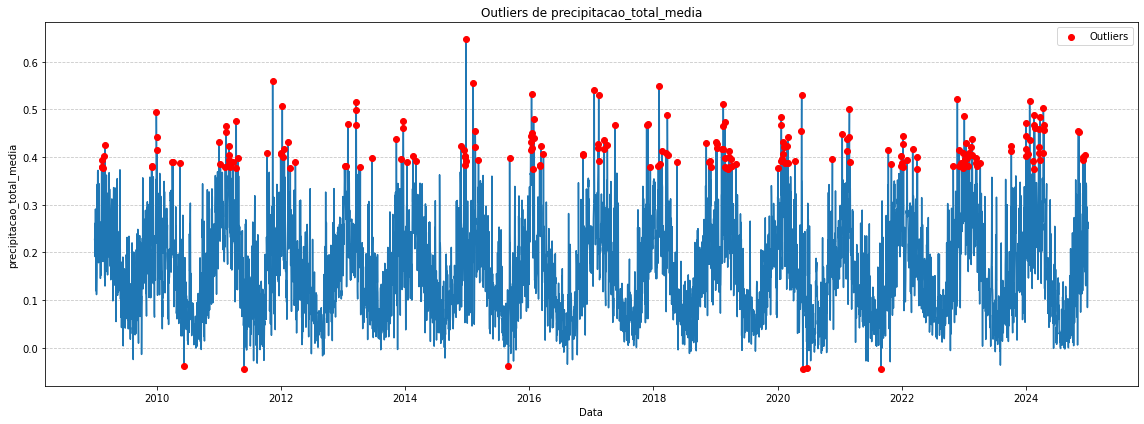

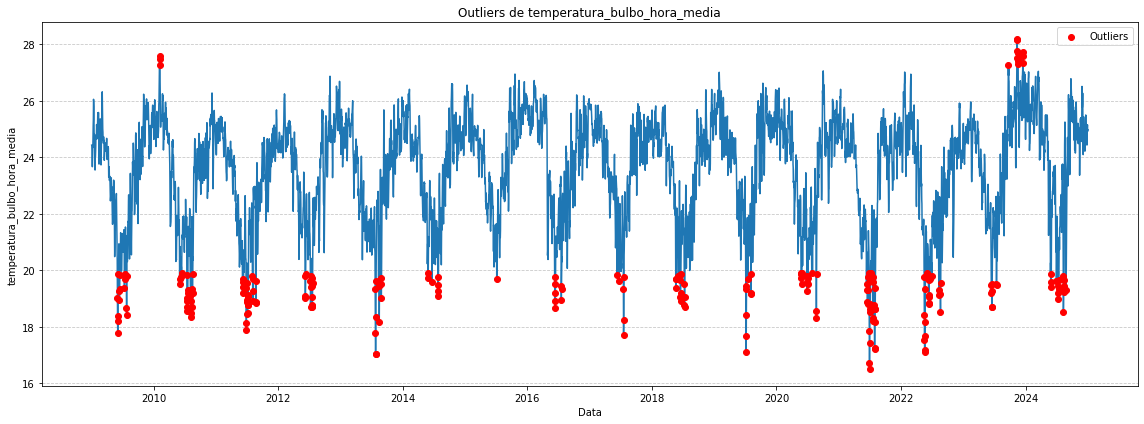

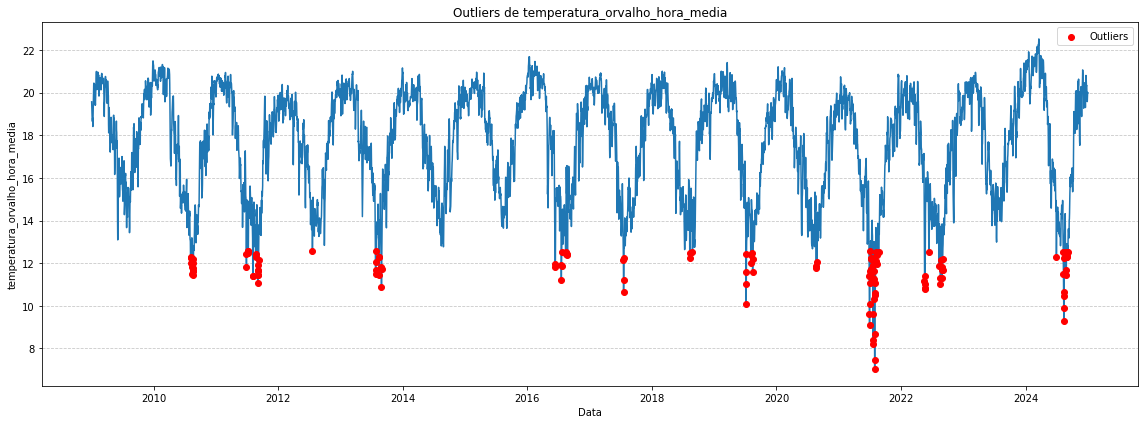

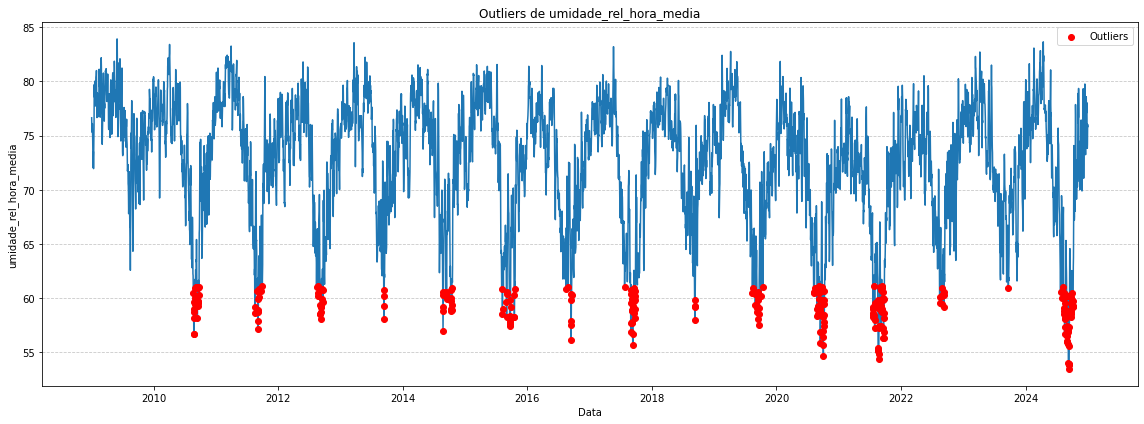

In [117]:
for feature in selected_numerical_features:

    feature_data = filtered_data_residual[["data", feature]]
    feature_data = feature_data.set_index("data")

    feature_labels = filtered_data_residual[["data", f"{feature}_outlier"]]
    feature_labels = feature_labels.set_index("data")

    feature_outliers = feature_labels[feature_labels == 1].dropna().index

    plt.figure(figsize=(16, 6))
    plt.plot(feature_data.index, feature_data[feature])
    plt.scatter(
        feature_outliers, 
        feature_data.loc[feature_outliers], 
        color='red',
        label='Outliers',
        zorder=3)
    plt.title(f"Outliers de {feature}")
    plt.xlabel("Data")
    plt.ylabel(feature)
    plt.legend()
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

# Exportando Resultados

In [ ]:
filtered_data_raw.to_csv(f"{MODULE_PATH}/sources/processed/selected_features_complete_df.csv", index=False)